In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def set_fontsize(ax, fs):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.title.set_size(fs)

In [5]:
%%time
from quantumoperators import *
from hamiltonianoperators import *

Jmax = 6      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

HamiltonianJ6 = Hamiltonian(Jmax, I_Tl, I_F)

Wall time: 59.1 s


# Loading Trajectories and Fields

In [6]:
from trajectories import *
positions = load_trajectories('positions_545.mat')
velocities = load_velocities('velocities_545.mat')

t, (xT, yT, zT), (xVelocity, yVelocity, zVelocity) = get_time_position_velocity(positions, velocities)

In [7]:
interpolateTrajectories = []
for idInt in range(t.shape[1]):
    interpolateTrajectories.append((make_interpolate(t[:,idInt], xT[:,idInt], yT[:,idInt], zT[:,idInt])))

In [8]:
del t, xT, yT, zT, xVelocity, yVelocity, zVelocity

In [9]:
from fields import *
c, intfun = fit_potential_xyz('potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
cP, intfunP = fit_potential_xyz('potentialElectrodes.fld', 0.022, 0.019, .45, 0)
funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

C:\Users\Olivier\Dropbox\Postdoc\Yale\CeNTREX Olivier\TlF Non-Adiabatic Transitions\fields.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(vander, f)[0]


# Propagation 30 G Trajectory 0

0.993412607211735
Wall time: 2min 41s


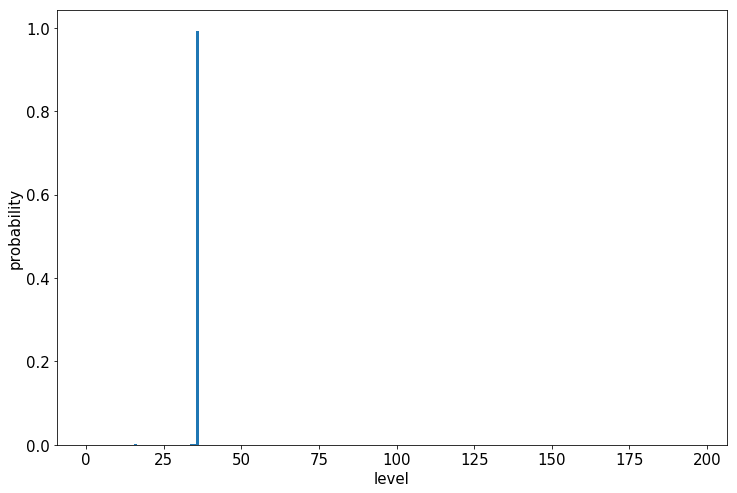

In [186]:
%%time 
from propagation import *
idT = 0
funB =  lambda x,y,z: (0, 30, 0)
funE = lambda x,y,z: (funEx(x,y,z), funEy(x,y,z), funEz(x,y,z))
t, H, phi = propagate_adaptive_save(HamiltonianJ6.create_hamiltonian, interpolateTrajectories[idT], funE, funB, 
                                    35, dtAdaptive = (5e-7, 1e-6), nstep = 2)

probabilities = calculate_state_probabilities(phi[-1], H[0])

fig, ax = plt.subplots(figsize = (12,8))
ax.bar(np.arange(1,len(probabilities)+1),probabilities, width = 1)
ax.set_xlabel('level')
ax.set_ylabel('probability');
set_fontsize(ax, 15)

print(np.abs(phi[-1].conj()@phi[0])**2)

In [187]:
from order_eigenstates import *

In [188]:
%%time
energies, eigenvectors = np.linalg.eigh(H)
energies1, eigenvectors1 = energies.copy(), eigenvectors.copy()
t1 = t.copy()

Wall time: 16.2 s


In [191]:
%%time
stride = 7
_, _, reorder = eigenshuffle(H[::stride], return_reorder = True)
energies, eigenvectors = reorder_full(energies,eigenvectors,reorder, stride)

Wall time: 5min 42s


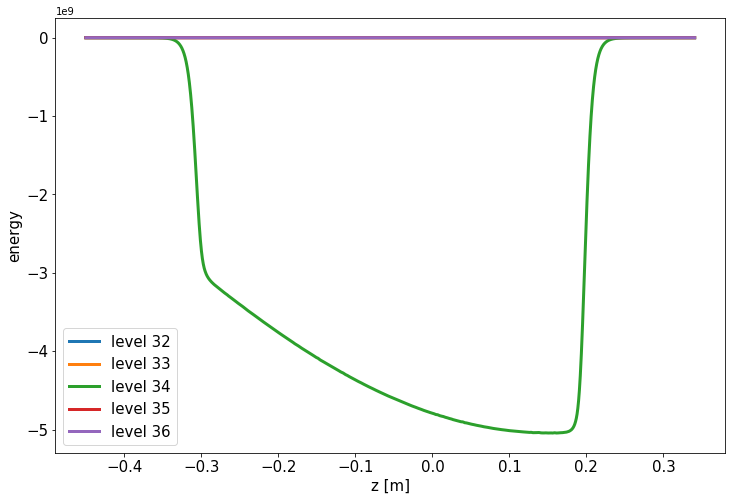

In [192]:
traj = interpolateTrajectories[323]

fig, ax = plt.subplots(figsize = (12,8))
nstart, nstop = 0, len(t)
for l in [31,32,33,34,35]:
    ax.plot(traj[2](np.array(t))[nstart:nstop], energies[nstart:nstop,l]-energies[nstart:nstop,35], 
            label = 'level {0}'.format(l+1), lw = 3);
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('energy')
set_fontsize(ax, 15)

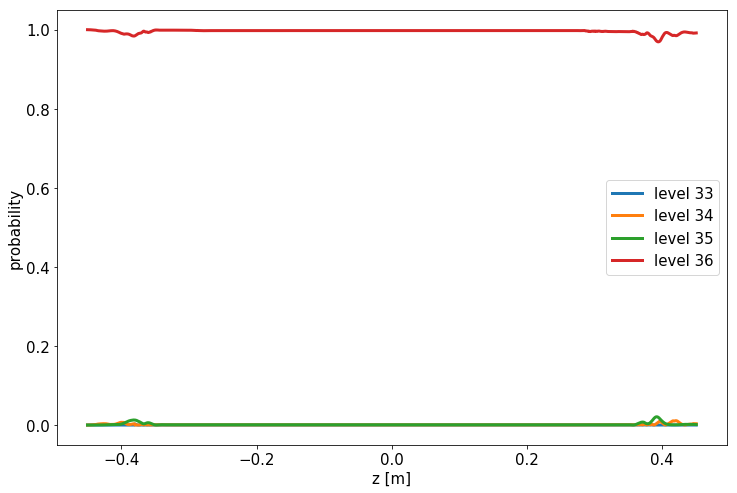

In [193]:
from propagation import *
probabilities = calculate_state_probabilities_eigvecs(phi, eigenvectors)

traj = interpolateTrajectories[idT]

fig, ax = plt.subplots(figsize = (12,8))
for idL in [32,33,34,35]:
    ax.plot(traj[2](t), probabilities[:,idL], lw = 3, label = 'level {0}'.format(idL+1));
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

del traj, idL

In [195]:
probabilities1 = probabilities.copy()

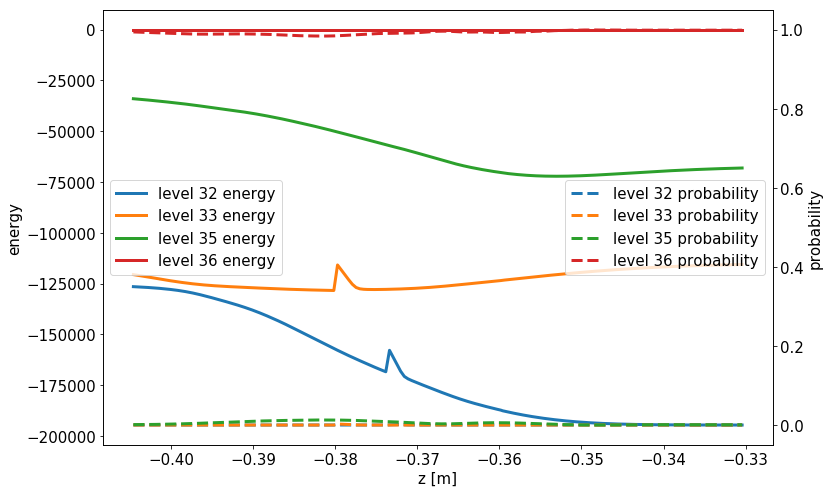

In [194]:
traj = interpolateTrajectories[idT]

fig, ax = plt.subplots(figsize = (12,8))
nstart, nstop = 100, 330
for idL in [31,32,34,35]:
    ax.plot(traj[2](t[nstart:nstop]), energies[nstart:nstop,idL]-energies[nstart:nstop,35], 
            label = 'level {0} energy'.format(idL+1), lw = 3);
ax.legend(loc = 6, fontsize = 15)
ax1 = ax.twinx()
for idL in [31,32,34,35]:
    ax1.plot(traj[2](t[nstart:nstop]), probabilities[nstart:nstop, idL], '--', lw = 3, 
             label = 'level {0} probability'.format(idL+1));
ax1.legend(loc = 5, fontsize = 15)
ax1.set_ylim(ymax = 1.05);
ax.set_xlabel('z [m]')
ax.set_ylabel('energy')
ax1.set_ylabel('probability')
set_fontsize(ax, 15)
set_fontsize(ax1, 15)

del traj, idL

In [163]:
funEVec = lambda x,y,z: np.array([funEx(x,y,z), funEy(x,y,z), funEz(x,y,z)]).T

In [204]:
idT = 0
nstart, nstop = 0, len(t1)-1

traj = interpolateTrajectories[idT]
xi, yi, zi = traj[0](t1)[nstart:nstop], traj[1](t1)[nstart:nstop], traj[2](t1)[nstart:nstop]

Evec = funEVec(xi,yi,zi)
angle = np.arccos(np.einsum('ij,ij->i',Evec[1:,:],Evec[:-1,:])/\
(np.linalg.norm(Evec[1:,:], axis = 1)*np.linalg.norm(Evec[:-1,:], axis = 1)))
wT = angle/(np.diff(t1)[nstart+1:nstop])

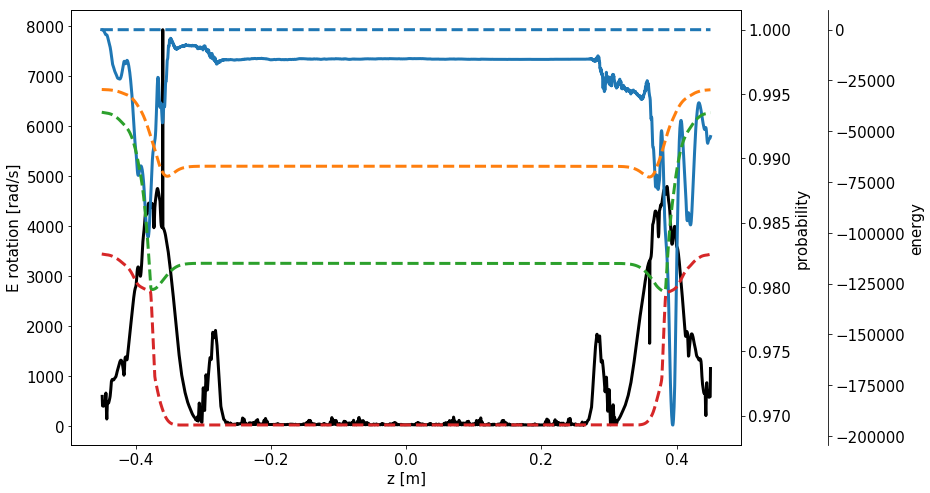

In [206]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(zi[1:], wT, lw = 3, c = 'k')
ax1 = ax.twinx()
ax1.plot(zi, probabilities1[nstart:nstop,35], lw = 3, c = 'C0')
ax1.set_ylabel('probability')
ax2 = ax.twinx()
for idL, l in enumerate(range(35,31,-1)):
    ax2.plot(zi, energies1[nstart:nstop,l]-energies1[nstart:nstop,35], '--', lw = 3)
ax2.set_ylabel('energy')
ax2.spines["right"].set_position(("axes", 1.13))
ax.set_ylabel('E rotation [rad/s]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)
set_fontsize(ax1, 15)
set_fontsize(ax2, 15)

In [208]:
print(len(t1), len(wT))

2434 2432


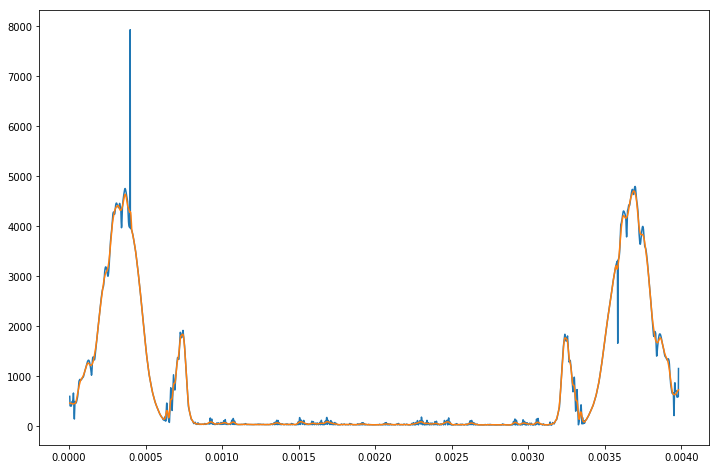

In [221]:
from statsmodels.nonparametric.smoothers_lowess import lowess
filtered = lowess(wT, t1[2:], return_sorted = False, frac=0.01, it=0)
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t1[2:], wT, lw = 3)
ax.plot(t1[2:], filtered, '--', lw = 3)

# Propagation 30 G Trajectory 323

0.6081667247329163
Wall time: 2min 55s


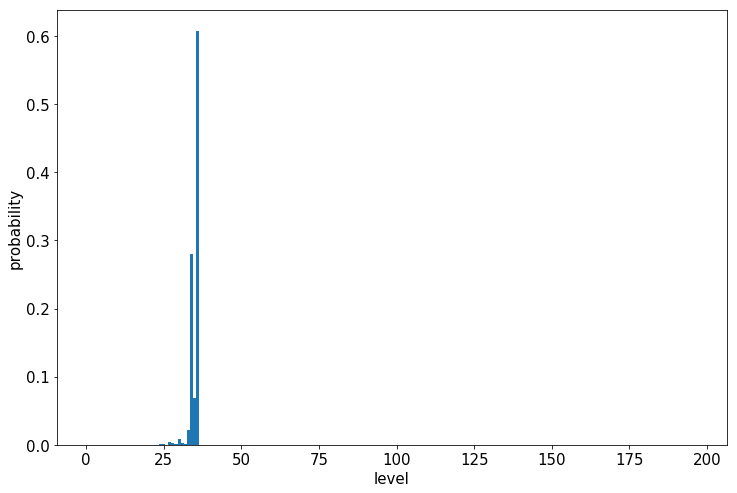

In [225]:
%%time 
from propagation import *
idT = 323
funB =  lambda x,y,z: (0, 30, 0)
funE = lambda x,y,z: (funEx(x,y,z), funEy(x,y,z), funEz(x,y,z))
t, H, phi = propagate_adaptive_save(HamiltonianJ6.create_hamiltonian, interpolateTrajectories[idT], funE, funB, 
                                    35, dtAdaptive = (5e-7, 1e-6), nstep = 2)

probabilities = calculate_state_probabilities(phi[-1], H[0])

fig, ax = plt.subplots(figsize = (12,8))
ax.bar(np.arange(1,len(probabilities)+1),probabilities, width = 1)
ax.set_xlabel('level')
ax.set_ylabel('probability');
set_fontsize(ax, 15)

print(np.abs(phi[-1].conj()@phi[0])**2)

In [226]:
%%time
energies, eigenvectors = np.linalg.eigh(H)

Wall time: 15.1 s


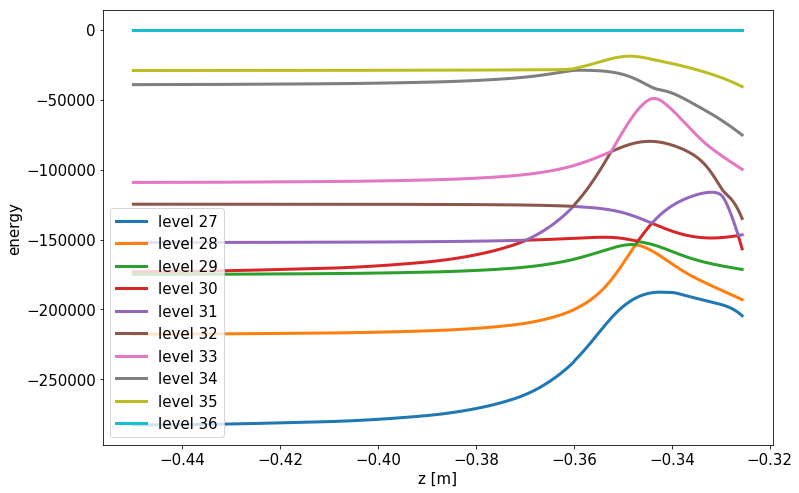

In [227]:
traj = interpolateTrajectories[idT]

fig, ax = plt.subplots(figsize = (12,8))
nstart, nstop = 0, 400
for l in range(26,36):
    ax.plot(traj[2](np.array(t))[nstart:nstop], energies[nstart:nstop,l]-energies[nstart:nstop,35], 
            label = 'level {0}'.format(l+1), lw = 3);
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('energy')
set_fontsize(ax, 15)

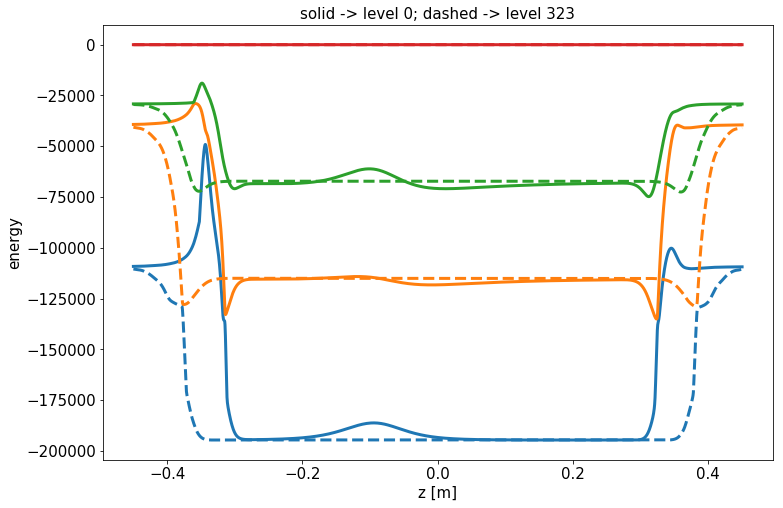

In [228]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
traj = interpolateTrajectories[idT]

fig, ax = plt.subplots(figsize = (12,8))
for idL, l in enumerate(range(32,36)):
    nstart, nstop = 0, len(t)
    traj = interpolateTrajectories[323]
    ax.plot(traj[2](np.array(t))[nstart:nstop], energies[nstart:nstop,l]-energies[nstart:nstop,35], 
            label = 'level {0}'.format(l+1), lw = 3, color = colors[idL]);
    traj = interpolateTrajectories[0]
    nstart, nstop = 0, len(t1)
    ax.plot(traj[2](np.array(t1))[nstart:nstop], energies1[nstart:nstop,l]-energies1[nstart:nstop,35], '--', 
            label = 'level {0}'.format(l+1), lw = 3, color = colors[idL]);
traj = interpolateTrajectories[323]
ax.set_xlabel('z [m]')
ax.set_ylabel('energy')
ax.set_title('solid -> level 0; dashed -> level 323')
set_fontsize(ax, 15)

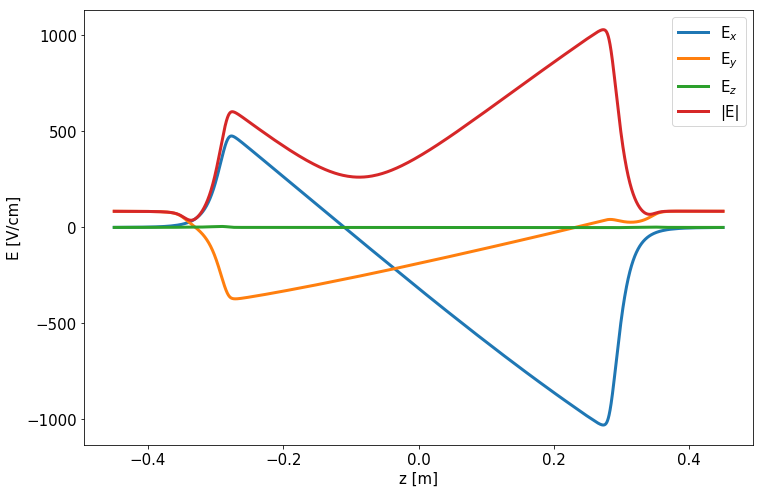

In [229]:
idT = 323
nstart, nstop = 0, len(t)

traj = interpolateTrajectories[idT]
xi, yi, zi = traj[0](t)[nstart:nstop], traj[1](t)[nstart:nstop], traj[2](t)[nstart:nstop]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(zi, funEx(xi,yi,zi), lw = 3, label = 'E$_x$')
ax.plot(zi, funEy(xi,yi,zi), lw = 3, label = 'E$_y$')
ax.plot(zi, funEz(xi,yi,zi), lw = 3, label = 'E$_z$')
ax.plot(zi, np.sqrt(funEx(xi,yi,zi)**2+funEy(xi,yi,zi)**2+funEz(xi,yi,zi)**2), lw = 3, 
        label = '|E|')
ax.set_ylabel('E [V/cm]')
ax.set_xlabel('z [m]')
ax.legend(fontsize = 15)
set_fontsize(ax, 15)

In [230]:
funEVec = lambda x,y,z: np.array([funEx(x,y,z), funEy(x,y,z), funEz(x,y,z)]).T

In [244]:
idT = 323
nstart, nstop = 0, len(t)-1

traj = interpolateTrajectories[idT]
xi, yi, zi = traj[0](t)[nstart:nstop], traj[1](t)[nstart:nstop], traj[2](t)[nstart:nstop]

Evec = funEVec(xi,yi,zi)
angle = np.arccos(np.einsum('ij,ij->i',Evec[1:,:],Evec[:-1,:])/\
(np.linalg.norm(Evec[1:,:], axis = 1)*np.linalg.norm(Evec[:-1,:], axis = 1)))
wT = angle/(np.diff(t)[nstart+1:nstop])

In [245]:
probabilities = calculate_state_probabilities_eigvecs(phi, eigenvectors)

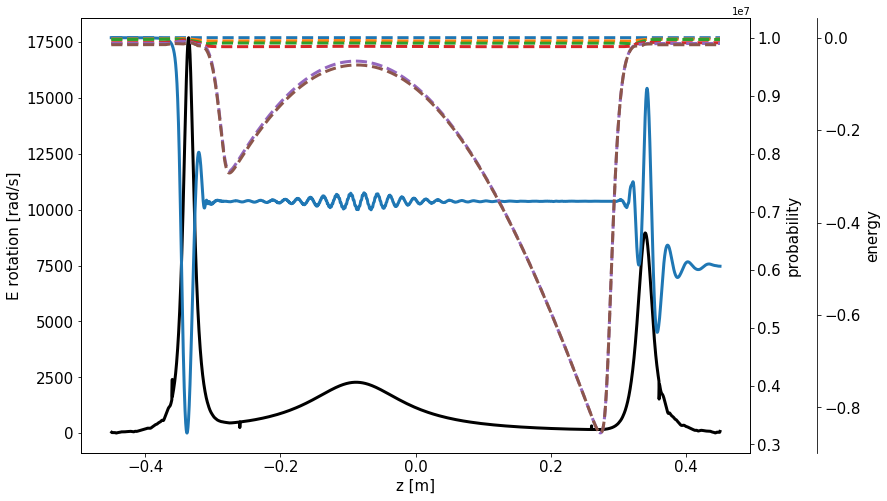

In [246]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(zi[1:], wT, lw = 3, c = 'k')
ax1 = ax.twinx()
ax1.plot(zi, probabilities[nstart:nstop,35], lw = 3, c = 'C0')
ax1.set_ylabel('probability')
ax2 = ax.twinx()
for idL, l in enumerate(range(35,29,-1)):
    ax2.plot(zi, energies[nstart:nstop,l]-energies[nstart:nstop,35], '--', lw = 3)
ax2.set_ylabel('energy')
ax2.spines["right"].set_position(("axes", 1.1))
ax.set_ylabel('E rotation [rad/s]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)
set_fontsize(ax1, 15)
set_fontsize(ax2, 15)

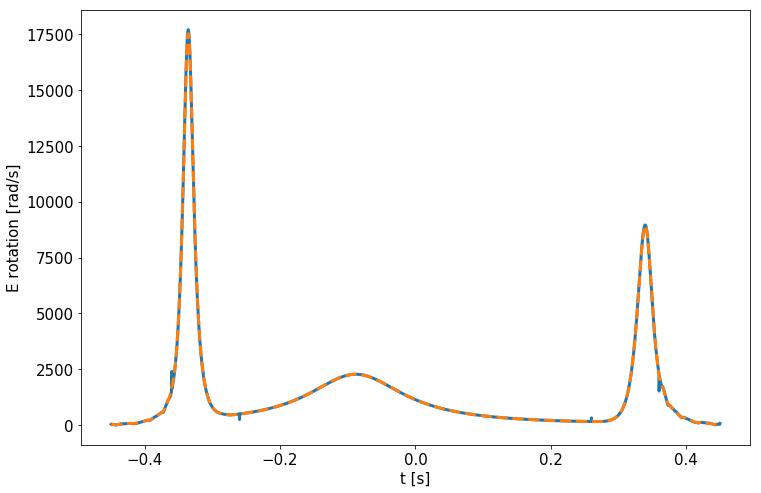

In [247]:
from statsmodels.nonparametric.smoothers_lowess import lowess
filtered = lowess(wT, t[2:], return_sorted = False, frac=0.01, it=0)
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(zi[1:], wT, lw = 3)
ax.plot(zi[1:], filtered, '--', lw = 3)
ax.set_xlabel('t [s]')
ax.set_ylabel('E rotation [rad/s]')
set_fontsize(ax, 15)

In [248]:
zi[np.argmax(filtered)]

-0.3357681867164903

In [234]:
angleOrigin = np.zeros(Evec.shape)
angleOrigin[:,0] = 1
angleWRTOrigin = np.arccos(np.einsum('ij,ij->i',Evec,angleOrigin)/\
(np.linalg.norm(Evec, axis = 1)*np.linalg.norm(angleOrigin, axis = 1)))

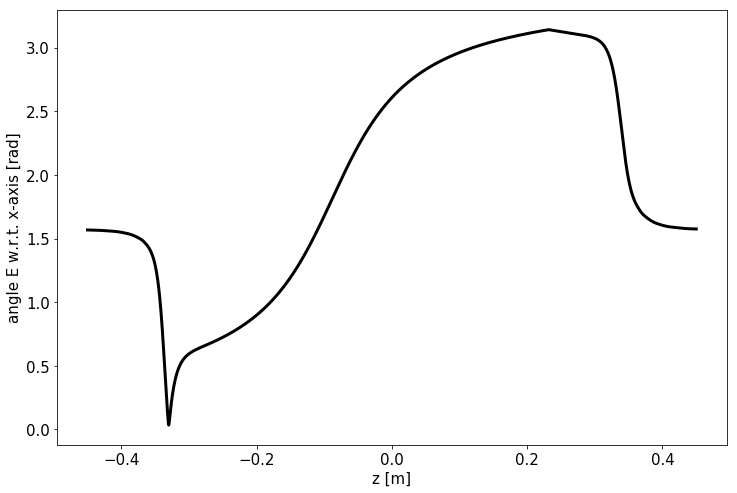

In [235]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(zi, angleWRTOrigin, lw = 3, c = 'k')
ax.set_xlabel('z [m]')
ax.set_ylabel('angle E w.r.t. x-axis [rad]')
set_fontsize(ax, 15)

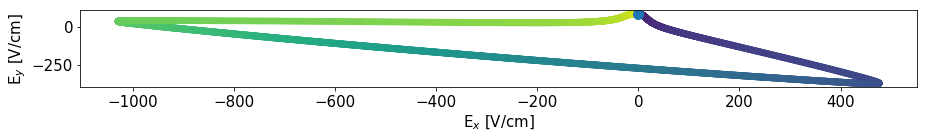

In [236]:
fig, ax = plt.subplots(figsize = (15,8))
ax.scatter(Evec[:,0], Evec[:,1], c = np.arange(0,len(Evec[:,0])))
ax.plot(Evec[0,0], Evec[0,1], '.', ms = 20)
ax.set_aspect(Evec[:,1].ptp()/Evec[:,0].ptp())
ax.set_xlabel('E$_x$ [V/cm]')
ax.set_ylabel('E$_y$ [V/cm]')
set_fontsize(ax, 15)

# Propagation 30 G Trajectory 323

0.9999843385081509
Wall time: 2min 53s


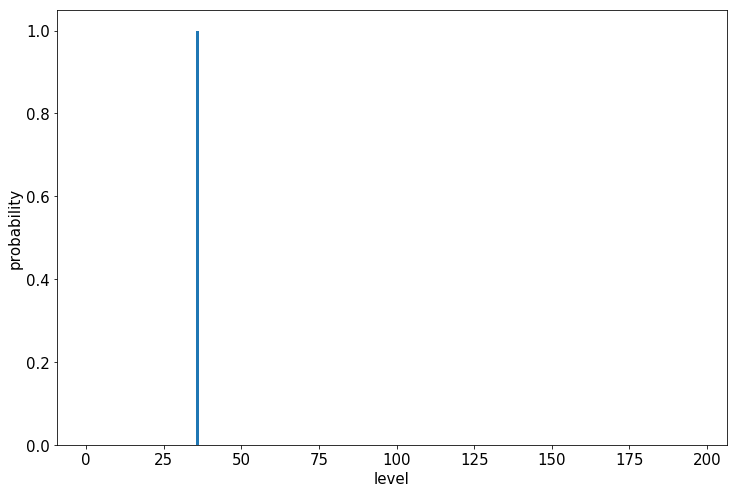

In [178]:
%%time 
from propagation import *
idT = 323
funB =  lambda x,y,z: (0, 30, 0)
funE = lambda x,y,z: (0, funEmag(x,y,z), 0)
t, H, phi = propagate_adaptive_save(HamiltonianJ6.create_hamiltonian, interpolateTrajectories[idT], funE, funB, 
                                    35, dtAdaptive = (5e-7, 1e-6), nstep = 2)

probabilities = calculate_state_probabilities(phi[-1], H[0])

fig, ax = plt.subplots(figsize = (12,8))
ax.bar(np.arange(1,len(probabilities)+1),probabilities, width = 1)
ax.set_xlabel('level')
ax.set_ylabel('probability');
set_fontsize(ax, 15)

print(np.abs(phi[-1].conj()@phi[0])**2)

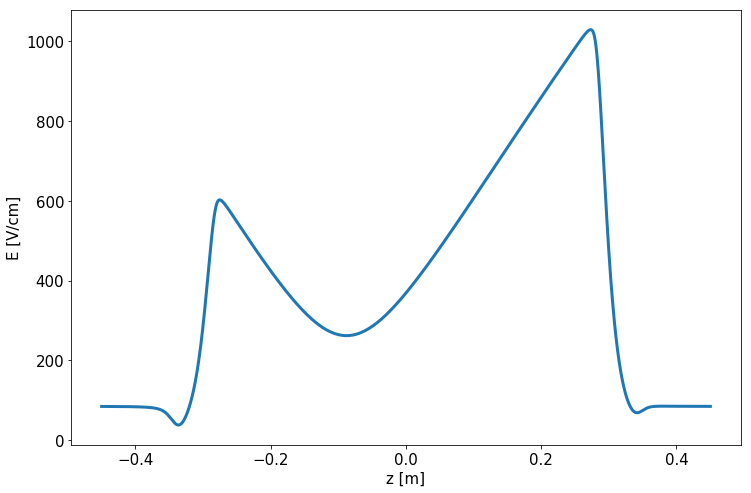

In [182]:
traj = interpolateTrajectories[idT]
xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(zi, funE(xi, yi,zi)[1], lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
set_fontsize(ax, 15)
del traj, xi, yi, zi